# **Importing All Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
import numpy as np

Dataset : https://www.kaggle.com/datasets/maimunulkjisan/rice-leaf-dataset-from-mendeley-data?resource=download

**Defining Programme Variable**


In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

**reading the dataset as a tf dataset.**


In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
   "/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/project_Rice_leaf_disease_detection/dataset/Rice_Leaf_Disease_Images",
    shuffle = True,
    image_size = (IMG_SIZE , IMG_SIZE) ,
    batch_size = BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [4]:
len(dataset)

186

**The Class Names are the Folder names respectively.**

In [5]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

In [6]:
# dataset = dataset.take(20 )

**Plotting some of the image .**

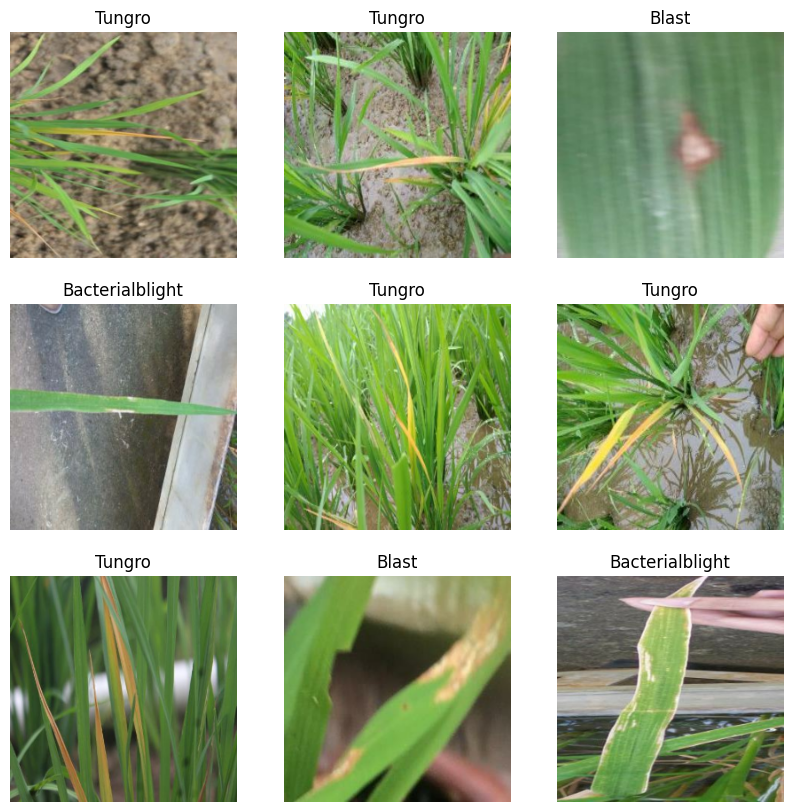

In [7]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


# **spliting into train,val,test dataset**

Defining a function for spliting method..

In [8]:
def split_dataset(ds, train_split, val_split, test_split, shuffle, shuffle_size ):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

Finding the spliting dataset.

In [9]:
train_ds , val_ds , test_ds = split_dataset(dataset, train_split = 0.8, val_split = 0.1,
                                                        test_split = 0.1, shuffle = True, shuffle_size = 1000 )

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

If GPU is busy training , prefatch will load the next set of batch from your disk and improve the performance.

## **dataset preprocessing**

In [11]:
resize_and_rescale = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0/255),
        tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE)
    ]
)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
 ])

Applying Data Augmentation to Train **Dataset**

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



Data augmentation is done for avoiding overfitting. :

# **creating CNN** with dropout of 20%

***Adding dropout layer is useful to avoid overfitting..***

**Also we will apply L2 Regularization on dense layer (Weight Decay)**

In [14]:
# from tensorflow.keras.regularizers import l2

filter_num = 32
kernel_size = 3
mx_pl = (2,2)
num_classes = len(class_names)

input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filter_num,kernel_size= (kernel_size,kernel_size),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D(mx_pl),
    layers.Conv2D(filter_num*2,(kernel_size,kernel_size),activation="relu"),
    layers.MaxPooling2D(mx_pl),
    layers.Conv2D(filter_num*2,(kernel_size,kernel_size),activation="relu"),
    layers.MaxPooling2D(mx_pl),
    layers.Conv2D(filter_num*2,(kernel_size,kernel_size),activation="relu"),
    layers.MaxPooling2D(mx_pl),
    layers.Conv2D(filter_num*2,(kernel_size,kernel_size),activation="relu"),
    layers.MaxPooling2D(mx_pl),
    layers.Conv2D(filter_num*2,(kernel_size,kernel_size),activation="relu"),
    layers.MaxPooling2D(mx_pl),


    layers.Flatten(),
    layers.Dense(64,activation="relu" ), # hidden layer
    layers.Dense(num_classes ,activation="softmax") # output layer
    #Softmax activation function: it normalizes the probability of the classes.

    ])
model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


In [17]:
len(train_ds)

148

In [18]:
EPOCHS = 4


model_data = model.fit(
    train_ds,
    epochs=EPOCHS ,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/4
148/148 ━━━━━━━━━━━━━━━━━━━━ 942s 3s/step - accuracy: 0.3813 - loss: 1.2420 - val_accuracy: 0.7153 - val_loss: 0.7789
Epoch 2/4
148/148 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.6868 - loss: 0.8103 - val_accuracy: 0.8021 - val_loss: 0.5401
Epoch 3/4
148/148 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.8026 - loss: 0.5185 - val_accuracy: 0.8420 - val_loss: 0.3673
Epoch 4/4
148/148 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.8528 - loss: 0.3838 - val_accuracy: 0.8802 - val_loss: 0.2945


In [19]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 735ms/step - accuracy: 0.9073 - loss: 0.2745


**Trying to predict from test dataset..**

first image to predict
actual label: Tungro
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
predicted label: Tungro


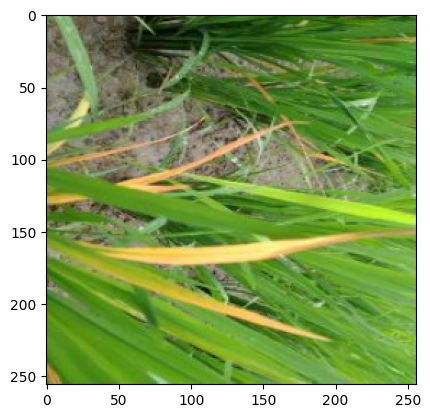

In [20]:
for image_batch , label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [21]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class , confidence

**....Predicting Some samples...**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


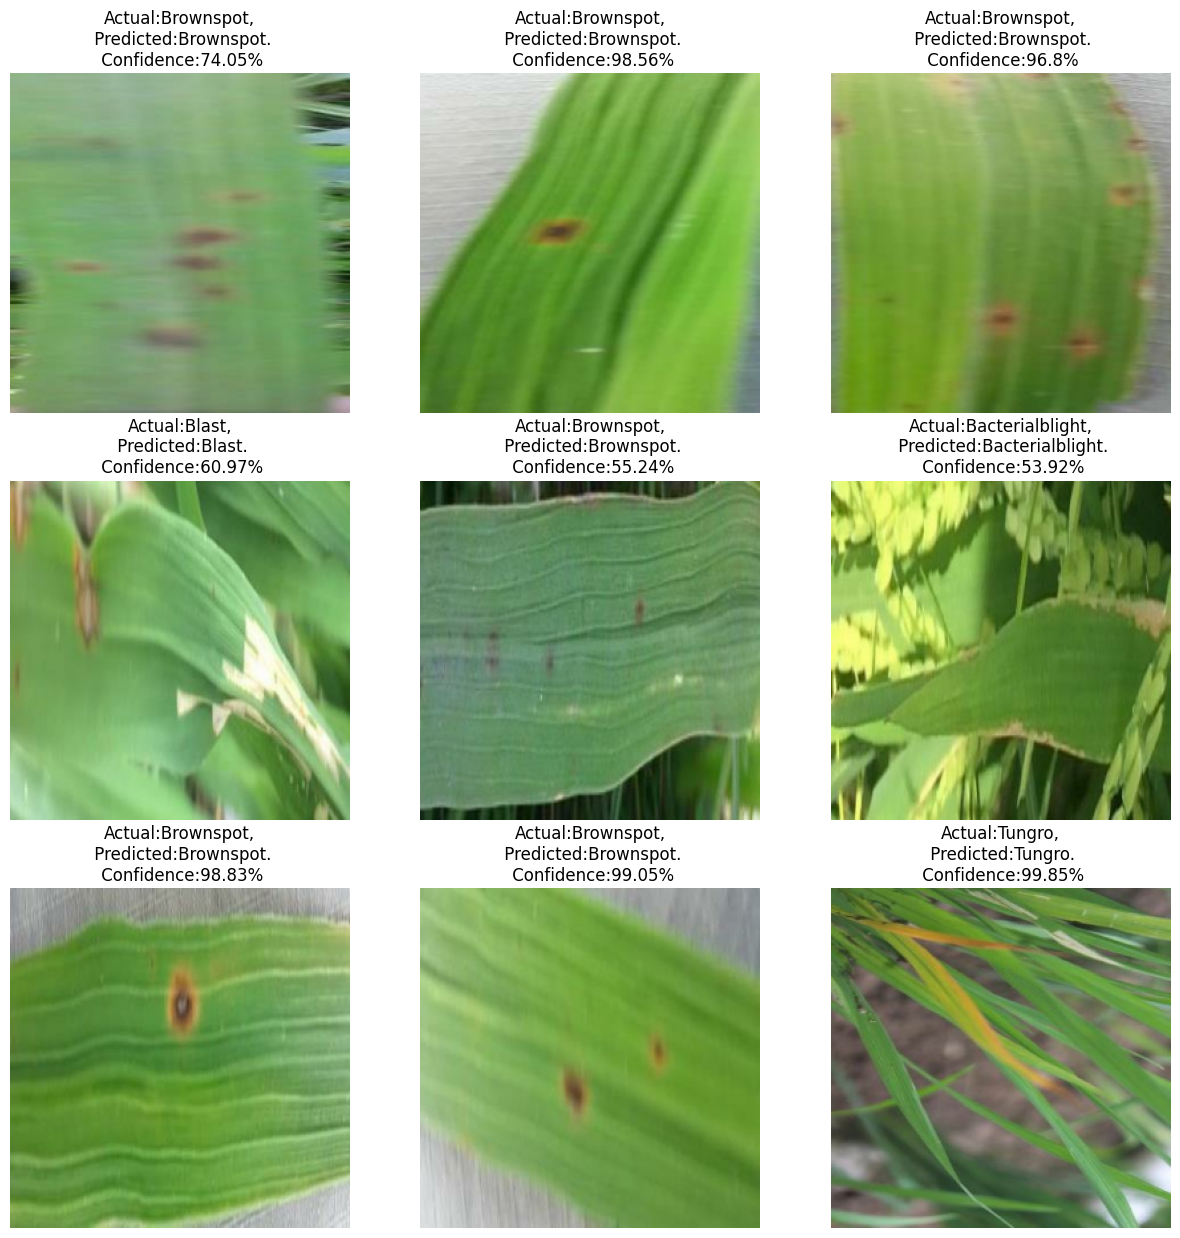

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class , confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
    plt.axis("off")

# **Saving the Model .**

In [23]:
model_version = 3
model.save(f"/content/drive/MyDrive/Colab Notebooks/DEEP LEARNING/project_Rice_leaf_disease_detection/model/{model_version}.keras")